In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator, InterpolatedUnivariateSpline, UnivariateSpline, splev, splrep
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
from settings import *

from tqdm import tqdm, trange, tqdm_notebook
fs = 20
fs_ticks = 16

import healpy as hp
from matplotlib.lines import Line2D
from copy import deepcopy

from tools import *
from tools import _trans

In [3]:
cgen = colors = ccref = [
    (0.24423453, 0.20678459, 0.41985299),
    (0.20692679, 0.48201774, 0.63812656),
    (0.29215894, 0.76144162, 0.67886578),
    (0.953125, 0.59765625, 0.02734375)
] # trust me :)
### alternatively more colors:
# gcm = plt.get_cmap('mako')
# cgen = colors = ccref = [gcm(th/5) for th in range(5)][1:]

In [4]:
# define location of experiments
poles = {
    'IceCube': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "tab:orange"},
    'Gen-2': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "magenta"},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg, "color": "tab:blue"},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg, "color": "k"},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg, "color": "tab:cyan"},
    'Plenum': {"color": "darkred"}
}

### First, get all effective areas (calculated in alternative_plenum_aeff.ipynb)

In [5]:
with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

40 log_10(energy) bins
50 declination bins
100 RA bins


In [6]:
# GEN-2 will have 7.5x effective area ==> 5times better discovery potential
aeff_2d["Gen-2"] = aeff_2d["IceCube"] * 5 ** (1 / 0.8)

### detection efficiency -- IceCube only

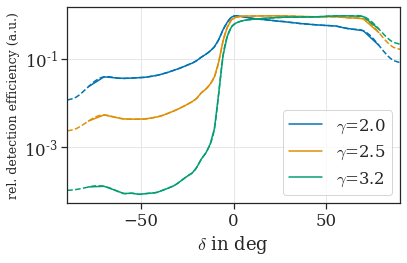

In [7]:
sindec_vals = np.linspace(-1, 1, 1000)
gammas = [2.0, 2.5, 3.2]
fig, ax = plt.subplots()
for gamma in gammas:
    Res = np.sum(aeff_eval_e_sd(aeff_2d["IceCube"]) * emids**(-gamma), axis=-1) / sindec_width
    Res_max = np.max(Res)
    Res /= np.max(Res)
    tck = InterpolatedUnivariateSpline(sindec_mids, np.log(Res))
    spl_val = np.exp(tck(sindec_vals))
    p = ax.plot(np.rad2deg(np.arcsin(sindec_mids)), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.rad2deg(np.arcsin(sindec_vals)), spl_val, ls='dashed', color=p[0].get_color())
    
ax.legend(loc=0)
ax.set_xlabel(r'$\delta$ in deg ')
ax.set_ylabel(r'rel. detection efficiency (a.u.)', fontsize="x-small")
ax.set_yscale('log')
ax.set_xlim(-90, 90)
fig.tight_layout()

## Get the detection efficiencies as a function of sin(dec) based on the effective areas calculated in alternative_plenum_aeff.ipynb

In [8]:
det_eff = dict()
det_eff_raw = dict()
for ii, gamma in enumerate(np.round(np.arange(1.4, 3.6, step=0.1), decimals=1)):
    det_eff[gamma] = dict()
    det_eff_raw[gamma] = dict()
    for det in aeff_2d:
        Res = np.sum(aeff_eval_e_sd(aeff_2d[det]) * emids**(-gamma), axis=-1) / sindec_width
        # pad with boundary values such that the detection efficiency is defined up to
        # sindec of -1 and 1
        padded_sd = np.concatenate([[-1], sindec_mids, [1]])
        padded_res = np.concatenate([[Res[0]], Res, [Res[-1]]])
        det_eff[gamma][det] = InterpolatedUnivariateSpline(padded_sd, np.log(padded_res))
        det_eff_raw[gamma][det] = np.copy(Res)        

### first get the current values for sens and disc pot


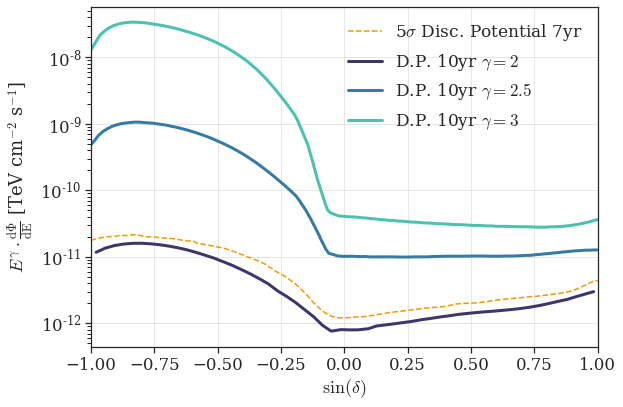

In [9]:
disc = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec = disc[:,0]
disc = disc[:,1]

tck_disc = splrep(sdec, np.log(disc), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    xvals, np.exp(spl_disc), color=cgen[-1],
    ls='dashed', label="5$\sigma$ Disc. Potential 7yr")
    
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^{\gamma} \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)


ps_disc = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', 
    color=colors[0],
    lw=3, label=r'D.P. 10yr $\gamma=2$')


ps_disc = np.genfromtxt('../resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', 
    color=colors[1],
    lw=3, label='D.P. 10yr $\gamma=2.5$')

ps_disc = np.genfromtxt('../resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', 
    color=colors[2],
    lw=3, label='D.P. 10yr $\gamma=3$')

ax.legend(
    fontsize=fs-3, loc='upper right',
    ncol=1, frameon=False,# bbox_to_anchor=(1.28, 0.5)
)
fig.tight_layout()
#fig.savefig(
#    '../plots/IceCube_ps_disc_pot.pdf', bbox_inches="tight")

### Idea:
* Discovery potential improvement for same time -> translated from scaling in effective area

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8} \equiv \left( \frac{\epsilon_{\rm new}}{\epsilon_{\rm IC}} \right)^{0.8}$

$\Rightarrow \Phi_{\rm new} = \frac{\Phi_{IC}}{R} = \Phi_{IC} \cdot \left( \frac{\epsilon_{\rm IC}}{\epsilon_{\rm new}} \right)^{0.8}$ (with detection efficiency = $\epsilon$)

* ALternative: adding known discovery potentials via
$ \Phi_{add} = \Phi_0 \oplus \Phi_1  := \left( \Phi_0^{-1/0.8} + \Phi_1^{-1/0.8} \right)^{-0.8} $

In [10]:
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

gamma = 2.5
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

reference_ddecs = np.array([-40, 0, 40])
reference_sdecs = np.sin(np.deg2rad(reference_ddecs))

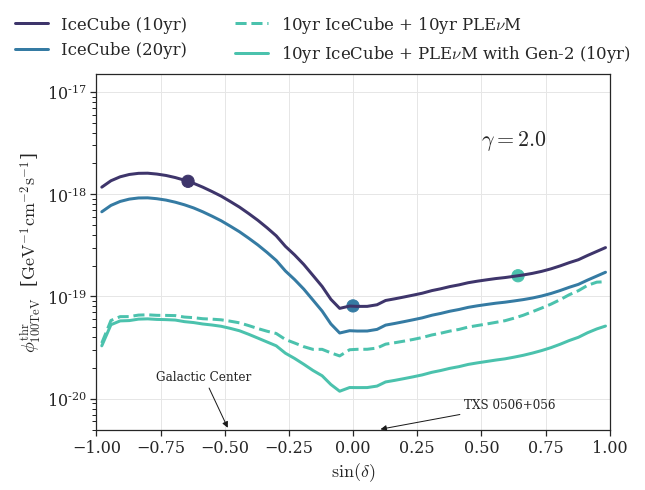

In [14]:
gamma= 2.0

ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3

f, ax = plt.subplots(figsize=(9, 7))

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2 \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75,0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=22 ,
         transform = ax.transAxes)


if gamma==2:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

elif gamma==2.5:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

### Need to find that data ...
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_cascade_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dotted')
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_track_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dashed')

f.tight_layout()
plt.subplots_adjust(top = 0.85)

fig.savefig(
    f'../plots/PLENUM_ps_disc_pot_comparison_gamma{gamma}.pdf', bbox_inches="tight")    
#'../plots/PLENUM_ps_disc_pot_time_evolution_g2_pCascades.pdf', bbox_inches="tight")

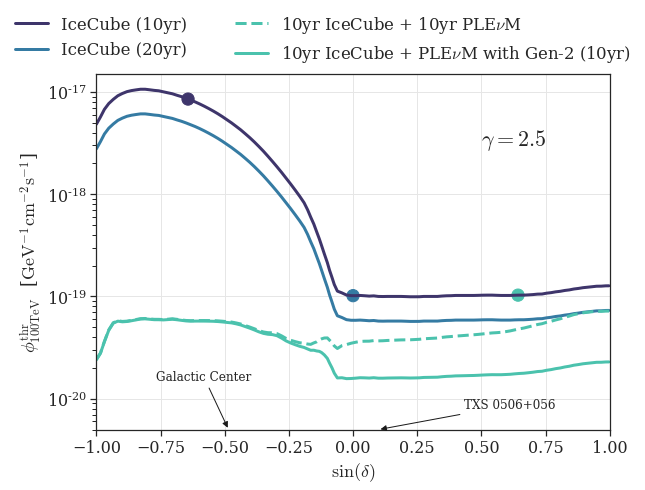

In [17]:
gamma= 2.5
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3


ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8


f, ax = plt.subplots(figsize=(9, 7))

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')

ax.scatter(
    reference_sdecs, 
    splev(reference_sdecs, spl_10yr[gamma]) * const,
    color=ccref[:3],
    s=150,
    alpha=1
)
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2 \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75,0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=22 ,
         transform = ax.transAxes)


if gamma==2:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

elif gamma==2.5:
    ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]",
              fontsize=fs-2)
    
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.set_ylim(5e-21, 1.5e-17) 
    # add the location of the galactic center and TXS
    ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

    ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

### Need to find that data ...
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_cascade_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dotted')
# km3net_cas = np.genfromtxt('/Users/mhuber/Documents/Km3NET_track_discPot_3years.csv', 
#                            delimiter=',')
# ax.plot(km3net_cas[:,0], km3net_cas[:,1]*1e-10 * (10/3.)**(-0.8), color='red', lw=2.,
#        ls='dashed')

f.tight_layout()
plt.subplots_adjust(top = 0.85)

fig.savefig(
    f'../plots/PLENUM_ps_disc_pot_comparison_gamma{gamma}.pdf', bbox_inches="tight")    
#'../plots/PLENUM_ps_disc_pot_time_evolution_g2_pCascades.pdf', bbox_inches="tight")

### todo: check time evolution plots

### Make a time evolution plot for the selected declinations

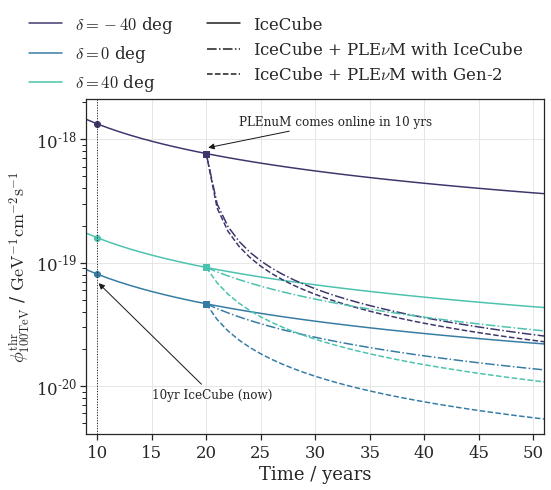

In [18]:
gamma = 2.0
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}$ deg", color=cgen[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=cgen[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=cgen[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=cgen[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=cgen[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(
    r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$ / $\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$")

ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate("10yr IceCube (now)", xy=(10, 7.e-20), xytext=(15, 0.8e-20),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
#ax.axvline(20, ls=":", lw=1, color="k")
ax.annotate("PLEnuM comes online in 10 yrs", xy=(20, 0.85e-18), xytext=(23, 1.3e-18),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
ax.set_xlim(9, 51)


handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)


## same plot, but gamma=2.5

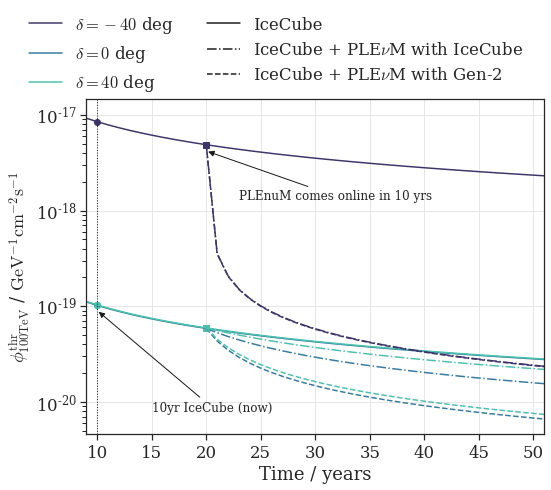

In [23]:
gamma = 2.5
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3

t_0 = 10
t_new = np.arange(8, 52)
base_disc_10yr = splev(reference_sdecs, spl_10yr[gamma])

fig, ax = plt.subplots(figsize=(8, 7))
for i, dd in enumerate(reference_ddecs):
    time_evolution_base = base_disc_10yr[i] * (t_0 / t_new) ** 0.8
    p = ax.plot(t_new, time_evolution_base * const, label=fr"$\delta = {dd}$ deg", color=cgen[i])
    ax.scatter(t_0, base_disc_10yr[i] * const, color=cgen[i])
    
t_1 = 20
t_new = np.arange(20, 52) # start Plenum after 20yr IC data (10yrs after "now")
for i, dd in enumerate(reference_ddecs):
    # base values at t_1 = 20yr
    # IC with 20 years
    base_ic = base_disc_10yr[i] * (t_0 / t_1) ** 0.8
    # plenum reference for 10 yrs data taking
    base_plenum = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - det_eff[gamma]["Plenum"](reference_sdecs[i]))* 0.8)
    
    # plenum with gen2 instead of icecube
    # first, subtract icecube eff from plenum eff
    pl_tmp = np.exp(det_eff[gamma]["Plenum"](reference_sdecs[i])) - np.exp(det_eff[gamma]["IceCube"](reference_sdecs[i]))
    # then, add gen2
    pl_tmp += np.exp(det_eff[gamma]["Gen-2"](reference_sdecs[i]))
    base_plenum_gen2 = base_disc_10yr[i] * np.exp((det_eff[gamma]["IceCube"](reference_sdecs[i]) - np.log(pl_tmp))* 0.8)
    # time evolution
    # plenum starts at t_1=20yrs
    base_plenum_evo = base_plenum * (t_0 / (t_new-t_1)) ** 0.8
    base_plenum_gen2_evo = base_plenum_gen2 * (t_0 / (t_new-t_1)) ** 0.8
    # combine both base vals
    # 20yr IceCube and from then on combined Plenum evolution
    time_evolution = (base_ic ** (-1/0.8) + base_plenum_evo ** (-1/0.8)) ** -0.8
    time_evolution_gen2 = (base_ic ** (-1/0.8) + base_plenum_gen2_evo ** (-1/0.8)) ** -0.8
    p = ax.plot(t_new, time_evolution * const, color=cgen[i], ls="-.")
    p = ax.plot(t_new, time_evolution_gen2 * const, color=cgen[i], ls="--")
    ax.scatter(t_new[0], time_evolution[0] * const, color=cgen[i], marker="s")

ax.set_yscale('log')
ax.set_xlabel(r"Time / years")
ax.set_ylabel(
    r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$ / $\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$")

ax.axvline(10, ls=":", lw=1, color="k")
ax.annotate("10yr IceCube (now)", xy=(10, 9.e-20), xytext=(15, 0.8e-20),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
#ax.axvline(20, ls=":", lw=1, color="k")
ax.annotate("PLEnuM comes online in 10 yrs", xy=(20, 4.2e-18), xytext=(23, 1.3e-18),
            arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
ax.set_xlim(9, 51)


handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-", label="IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="-.", label=r"IceCube + PLE$\nu$M with IceCube"
))
handles.append(Line2D(
    range(1), range(1), color="k", 
    ls="--", label=r"IceCube + PLE$\nu$M with Gen-2"
))
        
fig.legend(
    handles=handles,
    loc='upper center', #mode='expand',
    ncol=2, frameon=False
)
fig.tight_layout()
plt.subplots_adjust(top = 0.8)